In [1]:
%matplotlib inline
from genetic_oscillator_benchmarking import *

/home/twright/Drive/Documents/PhD/Notebooks/notebooks/genetic_oscillator_benchmarking.py:100: PyGIWarning: Notify was imported without specifying a version first. Use gi.require_version('Notify', '0.7') before import to ensure that the right version gets loaded.
  from gi.repository import Notify


## Properties

In [2]:
P = Atomic(var("x6") > 1)
P

Atomic(x6 > 1)

In [3]:
def prop(k):
    return (500/4)**2*(var("x4") - 0.003)**2 + 3*(var("x6") - 0.5)**2 < k

In [4]:
Q = Atomic(prop(0.1)); Q

Atomic(15625*(x4 - 0.00300000000000000)^2 + 3*(x6 - 0.500000000000000)^2 < 0.100000000000000)

In [5]:
I = RIF(2.5, 3)

In [6]:
duration = 1.5

In [7]:
import ipyparallel as ipp

In [19]:
rc = ipp.Client()
dview = rc[:]#.load_balanced_view()
dview.use_dill()

<AsyncResult: use_dill>

In [20]:
from gi.repository import Notify
Notify.init("LBUC Benchmarking")

True

In [21]:
def notify_when_done_ipp(res, task_description=None):
    dview.wait(res)
    
    if task_description is None:
        Notify.Notification.new("Benchmark run done!").show()
    else:
        Notify.Notification.new("Benchmark run done!",
                                task_description).show()

In [30]:
def notifyify(f):
    def h(*args, task_description=None, **kwargs):
        res = f(*args, **kwargs)
        notify_when_done_ipp(res, description)
        return res
    return h
    
def envify(f):
    def g(*args, **kwargs):
        from sage.all import Integer
        import sys
        sys.path.insert(0, "/home/twright/Documents/PhD/Notebooks/notebooks")
        return f(*args, **kwargs)
    return g

In [35]:
@envify
def test_fn(*args, **kwargs):
    from genetic_oscillator_benchmarking import test_monitoring
    return test_monitoring(*args, **kwargs)

In [24]:
def run_test(*args, task_description=None, **kwargs):
    res = dview.apply(
        test_fn, *args, **kwargs,
    )
    thread_pool.submit(notify_when_done_ipp, res, task_description)
    return res

In [25]:
def run(task_fn, *args, task_description=None, **kwargs):
    res = dview.apply(
        task, *args, **kwargs,
    )
    thread_pool.submit(notify_when_done_ipp, res, task_description)
    return res

In [26]:
P

Atomic(x6 > 1)

In [36]:
res = run_test(
    P,
    duration,
    task_description='Unmasked P | G(Q)',
    use_masks=False,
    symbolic_composition=True,
) 

In [37]:
res2 = run_test(
    P | F(I, Q),
    duration,
    task_description='Unmasked P | G(Q)',
    use_masks=False,
    symbolic_composition=True,
) 

In [41]:
res2.get(10)[0][1].plot().show()

TimeoutError: Result not ready.

## Launch Runs

In [90]:
duration = 1.5

In [91]:
results_unmasked = run_test(
    P | F(I, Q),
    duration,
    task_description='Unmasked P | G(Q)',
    use_masks=False,
    symbolic_composition=True,
)

In [92]:
results_masked = run_test(
    P | F(I, Q),
    duration,
    task_description='Masked P | F(Q)',
    use_masks=True,
    symbolic_composition=True,
)

In [93]:
results_masked_no_symbolic = run_test(
    P | F(I, Q),
    duration,
    task_description='Masked P | F(Q)',
    use_masks=True,
    symbolic_composition=False,
)

In [94]:
results_masked_no_symbolic_no_selective = run_test(
    P | F(I, Q),
    duration,
    task_description='Masked P | F(Q) no sym no sel',
    use_masks=True,
    symbolic_composition=False,
    selective_unpreconditioning=False,
    
)

In [95]:
results_masked_no_selective = run_test(
    P | F(I, Q),
    duration,
    task_description='Masked P | F(Q) no sel',
    use_masks=True,
    symbolic_composition=True,
    selective_unpreconditioning=False,
    
)

In [96]:
results_unmasked_reversed = run_test(
    F(I, Q) | P,
    duration,
    task_description='Unmasked F(Q) | P',
    use_masks=False,
    symbolic_composition=True,
)

In [97]:
results_masked_reversed = run_test(
    F(I, Q) | P,
    duration,
    task_description='Masked F(Q) & P',
    use_masks=True,
    symbolic_composition=True,
)

In [99]:
results_masked.get(1)

TimeoutError: Result not ready.

# Analysis

In [67]:
import pandas as pd

In [68]:
def total_time_for_key(inst, ks):
    if isinstance(ks, str):
        ks = [ks]

    return sum(inst.total_time(k)
               for k in ks)


def total_times(results, keys, keys_short=None):
    ress = [
        f.result() for f in futures(results)
    ]
    if keys_short is None:
        keys_short = keys
    data = pd.DataFrame({
        short_key: [total_time_for_key(r[2], key) for r in ress]
        for short_key, key in zip(keys_short, keys)
    })
    data.insert(len(keys), 'Total',
                [r[1] for r in ress])
    return data

In [69]:
results_unmasked[0]['future'].result()[2].events

['Precomposing Contexts',
 'restoring globals',
 'capturing globals [on exit]',
 'Running Flow*',
 'mask intersect check',
 'tentative eval',
 'composing flowpipe',
 'whole domain eval',
 'post retrieve',
 'root detection',
 'root amalgamation',
 'prepare in check',
 'check boolean [unguarded]',
 'observer.check',
 'Monitoring atomic x6 > 1',
 'Monitoring atomic x4 < 0.0044',
 'Monitoring Signal for x6 > 1 | G([3.0000000000000000 .. 3.5000000000000000], x4 < 0.0044)']

In [70]:
cols_full = [
    'Running Flow*',
    f'Monitoring atomic {P}',
    f'Monitoring atomic {Q}',
    [
        f'Monitoring Signal for {P | G(I, Q)}',
        f'Monitoring Signal for {G(I, Q) | P}',
    ],
    'tentative eval',
    'root detection',
    'composing flowpipe',
]
cols_short = [
    'Flow*', 'P', 'Q', 'P | G(Q)',
    'tentative eval',
    'root detection',
    'composing flowpipe',
]

## Raw results

In [71]:
times_unmasked = total_times(
    results_unmasked,
    cols_full,
    cols_short,
)
times_unmasked

,Flow*,P,Q,P | G(Q),tentative eval,root detection,composing flowpipe,Total
0,51.599025,6.395787,39.829344,46.322496,3.242143,0.026164,40.385964,98.090237
1,60.315117,6.617105,39.457317,46.157910,3.211459,0.026503,40.218330,106.642945
2,59.835863,5.897619,39.708208,45.713136,3.281752,0.026263,39.774999,105.723314
3,50.751895,6.474179,43.988088,50.553225,3.841515,0.027000,43.804419,101.462306
4,49.874196,6.022131,39.197219,45.309449,3.196713,0.026056,39.472448,95.328560


In [72]:
times_unmasked['Flow*'].std()

5.151358107997558

In [73]:
times_masked = total_times(
    results_masked,
    cols_full,
    cols_short,
)
times_masked

,Flow*,P,Q,P | G(Q),tentative eval,root detection,composing flowpipe,Total
0,50.194442,4.529647,5.707812,10.328794,0.872809,0.005202,8.783137,60.679837
1,50.843219,4.840234,7.473095,12.406711,1.110436,0.005645,10.517627,63.411967
2,54.523299,4.719995,6.152996,10.951844,0.937863,0.005363,9.321006,65.634893
3,50.491640,4.593885,5.831132,10.506449,0.897418,0.005248,8.936787,61.139756
4,52.438623,4.646413,6.122736,10.868738,0.934771,0.005433,9.206989,63.483314


In [74]:
times_masked['Flow*'].std()

1.8012132041443214

## Comparison

In [75]:
series = ['masked', 'unmasked',
          'masked_reversed', 'unmasked_reversed']
# total_timess = {
#    s: pd.load_csv(f'data/analysis3_raw_{s}.csv')
#    for s in series 
# }
total_timess = {
    s: total_times(eval(f'results_{s}'), cols_full, cols_short)
    for s in series 
}

In [79]:
for s, d in total_timess.items():
    d.to_csv(f'data/analysis3_raw_{s}.csv')

In [76]:
comparison = pd.DataFrame({
    s: total_times.mean()
    for s, total_times in total_timess.items()
})

In [81]:
comparison

,masked,unmasked,masked_reversed,unmasked_reversed
Flow*,51.698245,54.475219,52.862549,55.707290
P,4.666035,6.281364,4.983861,6.595809
Q,6.257554,40.436035,20.109990,42.201623
P | G(Q),11.012507,46.811243,0.000000,48.893257
tentative eval,0.950660,3.354716,1.158478,2.663521
root detection,0.005378,0.026397,0.015140,0.027092
composing flowpipe,9.353109,40.731232,22.068476,42.259191
Total,62.869954,101.449472,78.876031,104.754707


In [82]:
comparison2 = comparison.loc[['P', 'Q'],:].transpose()
comparison2

,P,Q
masked,4.666035,6.257554
unmasked,6.281364,40.436035
masked_reversed,4.983861,20.109990
unmasked_reversed,6.595809,42.201623


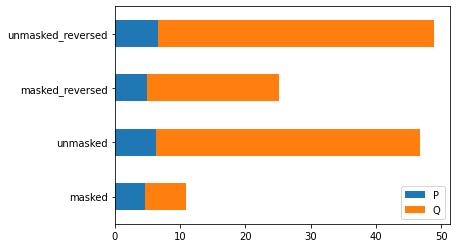

In [83]:
comparison2.plot(kind='barh', stacked=True)

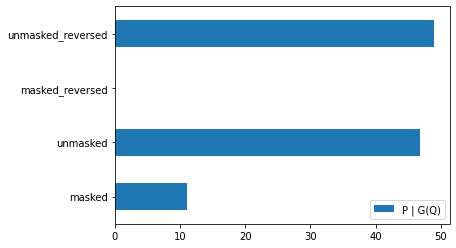

In [84]:
comparison3 = comparison.loc[['P | G(Q)'],:].transpose()
comparison3.plot(kind='barh')

In [85]:
restart_pool()